In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from skimage import io
from os.path import expanduser
from tqdm import tqdm
HOME = expanduser("~")
import os, sys
import SimpleITK as sitk
%load_ext autoreload
%autoreload 2

In [59]:
animal = 'DK39'
DIR = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps'
INPUT = os.path.join(DIR, 'CH1', 'thumbnail_cleaned')
MASKED = os.path.join(DIR, 'rotated_masked')
ELASTIX = os.path.join(DIR, 'elastix')

In [116]:
PATH = '/home/eddyod/programming/pipeline_utility'
sys.path.append(PATH)
from utilities.utilities_registration import register_test, register_from_tutorial

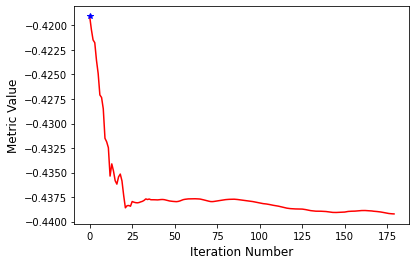

Final metric value: -0.4392246359992988
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Maximum number of iterations (25) exceeded.
rotation, xshift, yshift (0.014435252672401448, -0.4686368457046099, -3.0002315023950477)
center (1021.0486011500694, 514.7273150423844)
CPU times: user 30.2 s, sys: 885 ms, total: 31.1 s
Wall time: 24.1 s


In [156]:
%%time
# dk39, 169, 170 have a lot of shift and rotation
# 113, 114
# 137, 138 rotation off
fixed_index = str(113).zfill(3)
moving_index = str(114).zfill(3)

final_transform, fixed, moving, R = register_from_tutorial(INPUT, fixed_index, moving_index)    


# Always check the reason optimization terminated.
stop_condition = R.GetOptimizerStopConditionDescription()
iterations = R.GetOptimizerIteration()
metric_value = R.GetMetricValue()
finalParameters = final_transform.GetParameters()
fixedParameters = final_transform.GetFixedParameters()

print(f'Final metric value: {metric_value}')
print(f'Optimizer\'s stopping condition, {condition}')
print('rotation, xshift, yshift', finalParameters)
print('center', fixedParameters)

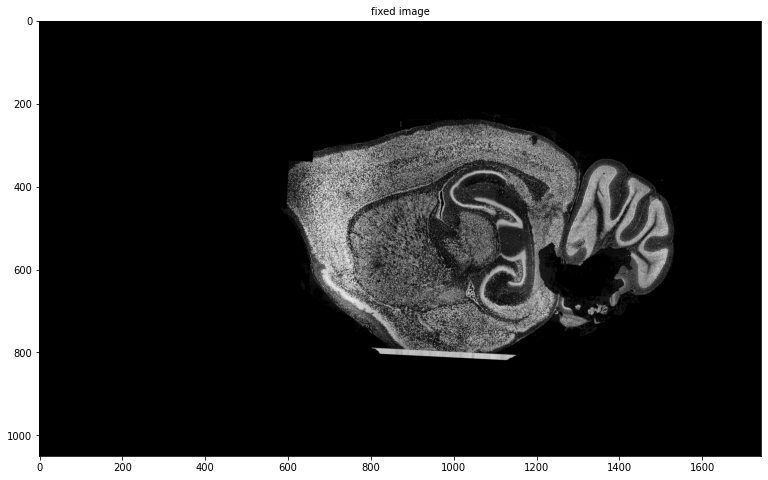

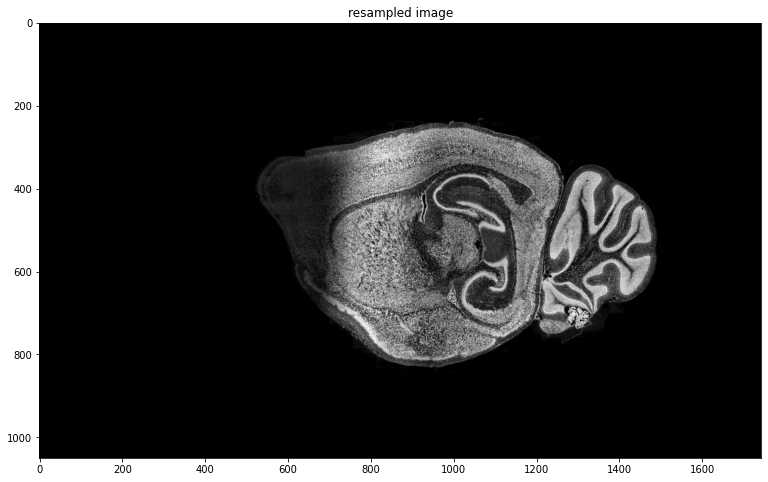

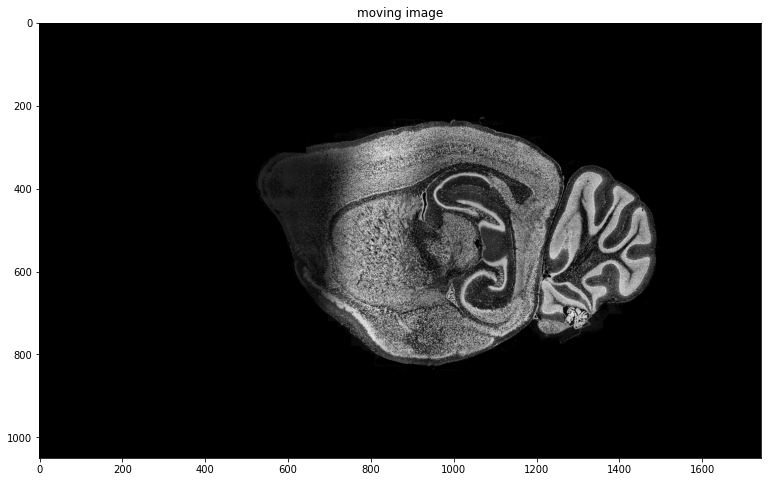

In [157]:
moving_resampled = sitk.Resample(moving, fixed, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
fig = plt.figure(figsize=(15,8))
plt.imshow(sitk.GetArrayViewFromImage(fixed), cmap='gray')
plt.title('fixed image', fontsize=10)

fig = plt.figure(figsize=(15, 8))
plt.imshow(sitk.GetArrayViewFromImage(moving_resampled), cmap='gray')
plt.title('resampled image')

fig = plt.figure(figsize=(15, 8))
plt.title('moving image')
plt.imshow(sitk.GetArrayViewFromImage(moving), cmap='gray')
    

In [168]:
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

In [165]:
import pickle
import json
from collections import OrderedDict
from utilities.file_location import FileLocationManager

fileLocationManager = FileLocationManager('DK39')
rotations = OrderedDict()
translations = OrderedDict()
rotations['junk'] = np.array([1,2,3,4])
translations['junkT'] = np.array([1,2,3,4])

rotation_storage = os.path.join(fileLocationManager.elastix_dir, 'rotations.pickle')    
save_dict(rotations, rotation_storage)